 ### 1. (Feature Extraction)
 

# Resize each cropped image to a 224 × 224 pixel image and Normalizing

In [9]:
import os

# Path to the Cropped dataset
dataset_path = "./Cropped/"

# List all classes (folders) in the dataset
classes = os.listdir(dataset_path)

print(f"Classes (Folders) in the Dataset: {classes}")

# Print the first few image file names from each class folder
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    print(f"\nClass: {class_name}")
    images = os.listdir(class_path)[:5]  # Display first 5 images
    for img in images:
        print(f"  - {img}")


Classes (Folders) in the Dataset: ['n02096177-cairn', 'n02096294-Australian_terrier', 'n02100735-English_setter', 'n02111500-Great_Pyrenees']

Class: n02096177-cairn
  - n02096177_1000-0.jpg
  - n02096177_10031-0.jpg
  - n02096177_10031-1.jpg
  - n02096177_10093-0.jpg
  - n02096177_10333-0.jpg

Class: n02096294-Australian_terrier
  - n02096294_1111-0.jpg
  - n02096294_1121-0.jpg
  - n02096294_1133-0.jpg
  - n02096294_1147-0.jpg
  - n02096294_1150-0.jpg

Class: n02100735-English_setter
  - n02100735_10030-0.jpg
  - n02100735_10038-0.jpg
  - n02100735_10064-0.jpg
  - n02100735_10086-0.jpg
  - n02100735_10097-0.jpg

Class: n02111500-Great_Pyrenees
  - n02111500_1031-0.jpg
  - n02111500_1048-0.jpg
  - n02111500_1050-0.jpg
  - n02111500_109-0.jpg
  - n02111500_1097-0.jpg



Class: n02096177-cairn


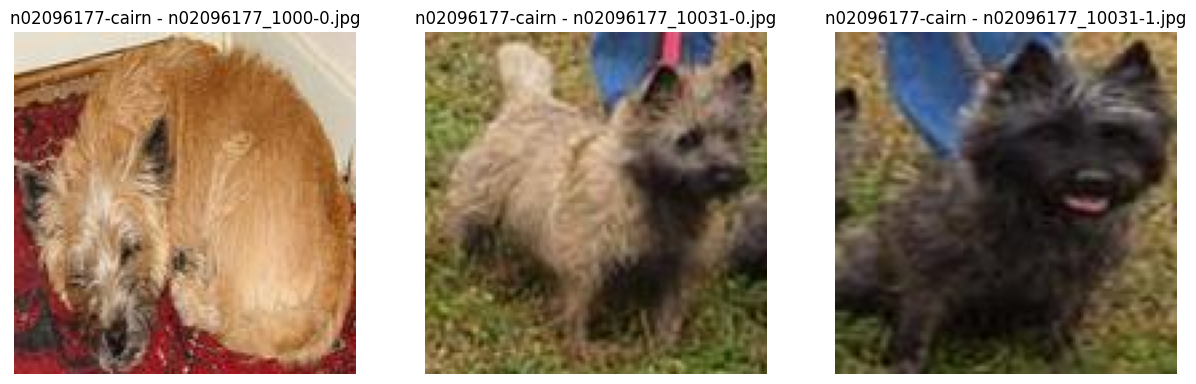


Class: n02096294-Australian_terrier


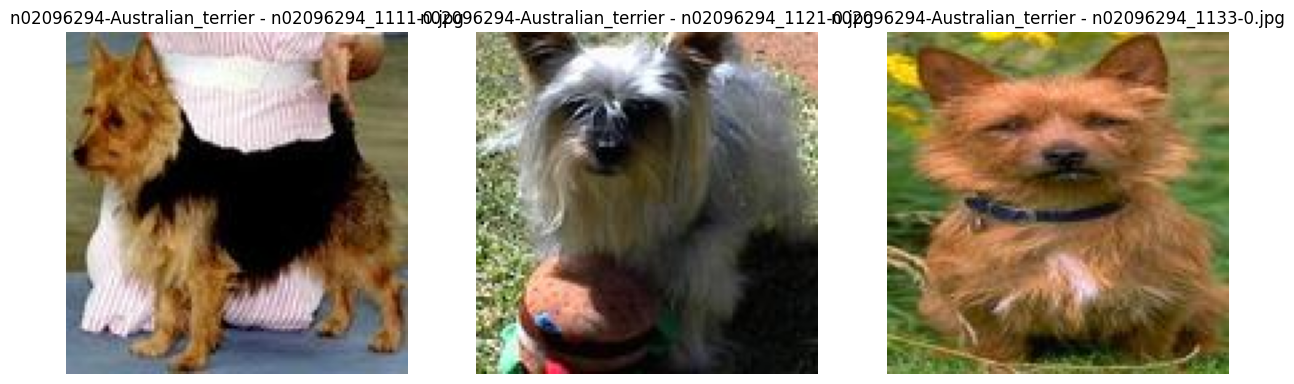


Class: n02100735-English_setter


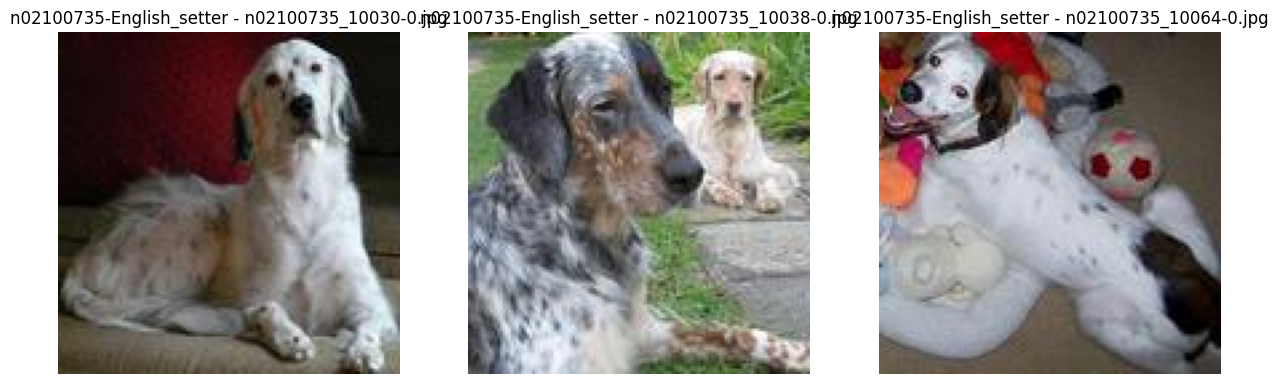


Class: n02111500-Great_Pyrenees


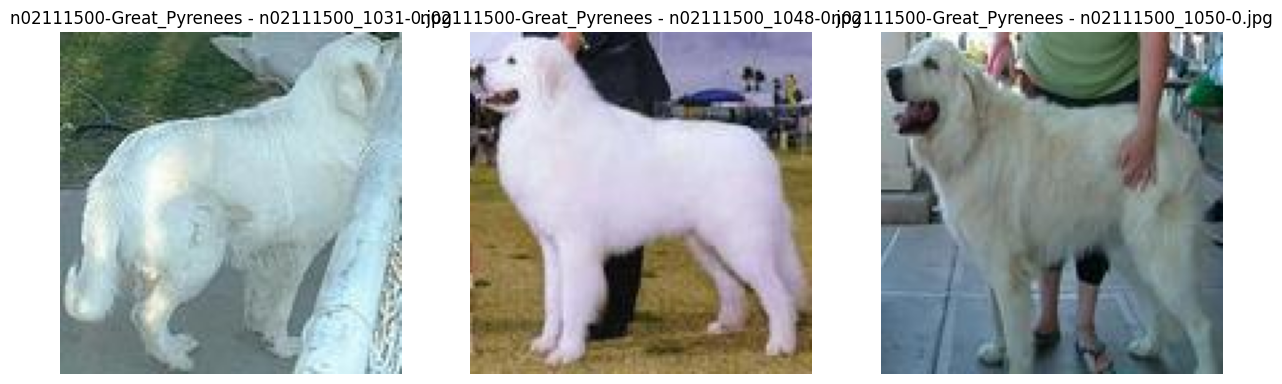

In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image


dataset_path = "./Cropped/"

# Number of images to display per class
num_images_to_display = 3

# List all classes
classes = os.listdir(dataset_path)

# Display images
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)[:num_images_to_display]  # Select the first few images
    
    print(f"\nClass: {class_name}")
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))
    
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        
        # Display image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{class_name} - {img_name}")
    
    plt.show()


In [21]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

# Define the path to your dataset and the output directory
dataset_path = './Cropped'  # Path to your Cropped dataset
output_path = './Resized'  # Path to save the resized images

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define image transformations: Resize, Normalize, and Convert to Tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset with transformations
dataset = ImageFolder(root=dataset_path, transform=transform)

# Function to save the resized images
def save_resized_images():
    for class_idx, class_name in enumerate(dataset.classes):
        class_folder = os.path.join(output_path, class_name)
        
        # Create the class folder if it doesn't exist
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        
        # Loop through each image in the dataset
        for idx, (image_tensor, label) in enumerate(dataset):
            if label == class_idx:
                # Convert tensor back to PIL Image for saving
                image_pil = transforms.ToPILImage()(image_tensor)
                
                # Save the image with the same name as in the original dataset
                image_name = dataset.imgs[idx][0].split(os.sep)[-1]  # Get image file name
                image_pil.save(os.path.join(class_folder, image_name))

# Call the function to save resized images
save_resized_images()

print("Resized images saved successfully in the 'Resized' folder.")


Resized images saved successfully in the 'Resized' folder.


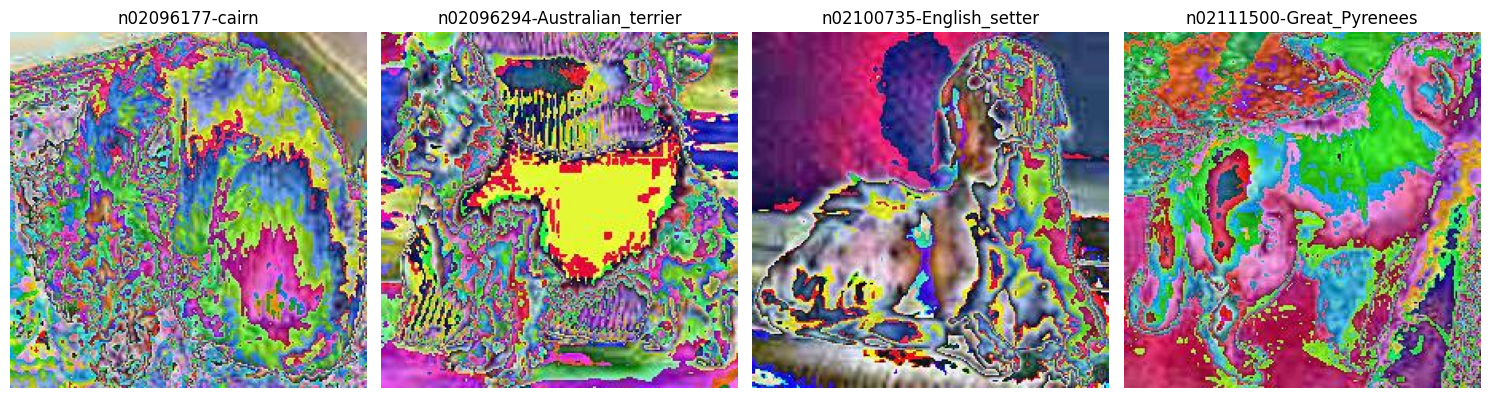

In [22]:
def view_resized_images():
    fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
    for idx, class_name in enumerate(classes):
        # Get a sample image from each class
        class_folder = os.path.join(output_path, class_name)
        image_files = os.listdir(class_folder)
        
        # Load the first image in the folder
        image_path = os.path.join(class_folder, image_files[0])
        image = Image.open(image_path)
        
        # Display the image
        axes[idx].imshow(image)
        axes[idx].axis('off')  # Hide axes for better visualization
        axes[idx].set_title(class_name)  # Set class name as title

    plt.tight_layout()
    plt.show()

# Call the function to view the images
view_resized_images()

## Extract features for each image from the last convolution layer of “ResNet18”.
### Reference : https://kozodoi.me/blog/20210527/extracting-features.


In [71]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os

# Define the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet18 model and move it to the correct device (CPU/GPU)
resnet18 = models.resnet18(weights="IMAGENET1K_V1")  # Note: Use weights argument to avoid deprecation warning
resnet18.to(device)  # Move the model to the same device as input image
resnet18.eval()  # Set the model to evaluation mode

# Get the last convolution layer (ResNet18 layer4 block)
last_conv_layer = resnet18.layer4[1].conv2

# List to store extracted features
features_list = []

# Function to use forward hook to capture the output of the last convolution layer
def hook_fn(module, input, output):
    features_list.append(output.cpu().detach().numpy())

# Register the hook to the last convolution layer
hook = last_conv_layer.register_forward_hook(hook_fn)

# Path to the Resized images folder
resized_path = 'Resized'

# List of all class names (subfolders inside the Resized folder)
classes = os.listdir(resized_path)

# Function to extract features from a limited number of images
def extract_features_from_images():
    for class_name in classes:
        class_folder = os.path.join(resized_path, class_name)
        image_files = os.listdir(class_folder)
        
        # Limit the number of images to print (e.g., first 5 images per class)
        count = 0
        for image_file in image_files:
            if count >= 5:  # Stop after 5 images
                break
            
            # Load the image without normalization
            image_path = os.path.join(class_folder, image_file)
            image = Image.open(image_path).convert("RGB")
            image = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension

            # Perform a forward pass to extract features via the hook
            resnet18(image)  # This will trigger the hook and store the features
            
            # Extract features from the hook
            features = features_list[-1]  # Get the latest features extracted
            
            # Print the shape of the extracted features
            print(f"Extracted features from {image_file} of class {class_name}: Shape = {features.shape}")
            
            count += 1  # Increment the counter
    
    # Remove the hook after extracting features
    hook.remove()

# Call the function to extract features from a limited number of images
extract_features_from_images()


Extracted features from n02096177_1000-0.jpg of class n02096177-cairn: Shape = (1, 512, 7, 7)
Extracted features from n02096177_10031-0.jpg of class n02096177-cairn: Shape = (1, 512, 7, 7)
Extracted features from n02096177_10031-1.jpg of class n02096177-cairn: Shape = (1, 512, 7, 7)
Extracted features from n02096177_10093-0.jpg of class n02096177-cairn: Shape = (1, 512, 7, 7)
Extracted features from n02096177_10333-0.jpg of class n02096177-cairn: Shape = (1, 512, 7, 7)
Extracted features from n02096294_1111-0.jpg of class n02096294-Australian_terrier: Shape = (1, 512, 7, 7)
Extracted features from n02096294_1121-0.jpg of class n02096294-Australian_terrier: Shape = (1, 512, 7, 7)
Extracted features from n02096294_1133-0.jpg of class n02096294-Australian_terrier: Shape = (1, 512, 7, 7)
Extracted features from n02096294_1147-0.jpg of class n02096294-Australian_terrier: Shape = (1, 512, 7, 7)
Extracted features from n02096294_1150-0.jpg of class n02096294-Australian_terrier: Shape = (1, 51

## 2. (DimensionReduction)Performdimensionreductiononyournewdogimagerepresentationdataset to reduce the dimension to 2 .

In [72]:
import numpy as np
import torch

# Prepare a list to hold the flattened feature vectors
flattened_features = []

# Counter to limit the number of features printed
print_limit = 5

# Flatten the features for all images (from the previous step where you extracted features)
for idx, feature in enumerate(features_list):
    if idx >= print_limit:  # Stop printing after the first `print_limit` features
        break
    
    print("Original feature shape:", feature.shape)  # Debugging: print the shape of the tensor
    
    # Check if the feature is a tensor or numpy array and handle accordingly
    if isinstance(feature, torch.Tensor):
        feature = feature.cpu()  # Ensure it's on CPU if it's a tensor
    elif isinstance(feature, np.ndarray):
        feature = torch.tensor(feature)  # Convert NumPy array to tensor (if needed)
    
    # Remove batch dimension and flatten the feature
    feature = feature.squeeze()  # Remove batch dimension, shape should be (512, 7, 7)
    print("Feature shape after squeeze:", feature.shape)  # Debugging: print shape after squeeze
    
    # Flatten the feature tensor to 1D
    flattened_feature = feature.view(-1)  # Shape should be (512*7*7,)
    print("Flattened feature shape:", flattened_feature.shape)  # Debugging: print flattened shape
    
    # Append the flattened feature
    flattened_features.append(flattened_feature.numpy())  # Convert to numpy and append

# Convert the list of flattened features into a numpy array
flattened_features = np.array(flattened_features)

# Check the shape of the flattened features
print("Shape of flattened features:", flattened_features.shape)

# Apply PCA to reduce dimensions to 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(flattened_features)

# Print the reduced features
print("Reduced features shape:", reduced_features.shape)


Original feature shape: (1, 512, 7, 7)
Feature shape after squeeze: torch.Size([512, 7, 7])
Flattened feature shape: torch.Size([25088])
Original feature shape: (1, 512, 7, 7)
Feature shape after squeeze: torch.Size([512, 7, 7])
Flattened feature shape: torch.Size([25088])
Original feature shape: (1, 512, 7, 7)
Feature shape after squeeze: torch.Size([512, 7, 7])
Flattened feature shape: torch.Size([25088])
Original feature shape: (1, 512, 7, 7)
Feature shape after squeeze: torch.Size([512, 7, 7])
Flattened feature shape: torch.Size([25088])
Original feature shape: (1, 512, 7, 7)
Feature shape after squeeze: torch.Size([512, 7, 7])
Flattened feature shape: torch.Size([25088])
Shape of flattened features: (5, 25088)
Reduced features shape: (5, 2)


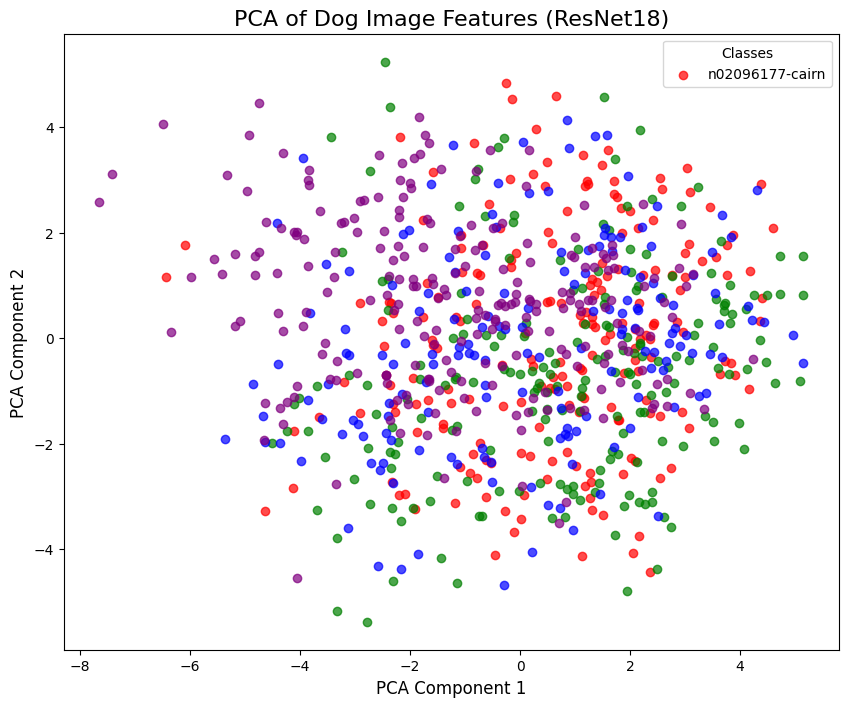

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA



# List of class names (dog breeds)
class_names = ['n02096177-cairn', 'n02096294-Australian_terrier', 'n02100735-English_setter', 'n02111500-Great_Pyrenees']

# Manually creating the labels based on the directory structure or filenames


labels = []
for class_name in class_names:
    # For each class, append the class name (label) for each image
    class_images = os.listdir(os.path.join("Cropped", class_name))
    labels.extend([class_name] * len(class_images))

# Define the color map for each class
colors = ['red', 'green', 'blue', 'purple']  # Assign colors for the classes
class_to_color = dict(zip(class_names, colors))  # Map class names to colors

# Perform PCA to reduce the dimensions to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_features)

# Plot the scatterplot with color coding based on the classes
plt.figure(figsize=(10, 8))

for i, label in enumerate(labels):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], color=class_to_color[label], label=label if i == 0 else "", alpha=0.7)

# Add a legend to differentiate the classes
plt.legend(loc='upper right', title="Classes")
plt.title("PCA of Dog Image Features (ResNet18)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.show()


 ### 3. (Clustering Algorithm) Perform clustering using the following approaches on the 2D dataset you preprocessed in Item 2:K-mean clustering and its variants for 𝐾 = 4

### (a) K-means clustering: (Use KMeans with init = ‘Random’)

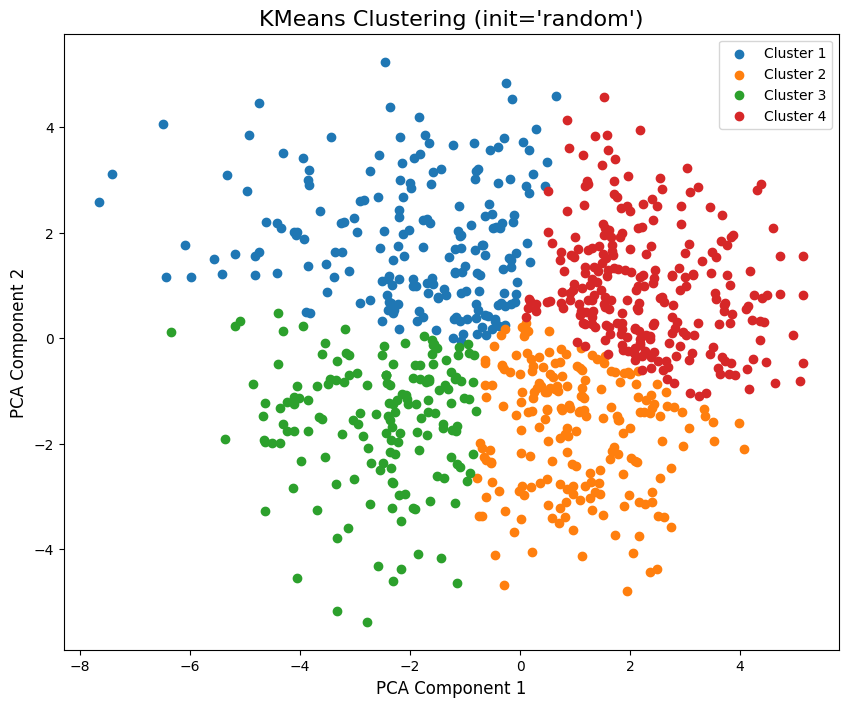

In [61]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering with init='random' for K=4
kmeans_random = KMeans(n_clusters=4, init='random', random_state=42)
kmeans_random.fit(pca_result)

# Get the predicted cluster labels
labels_kmeans = kmeans_random.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_random == i, 0], pca_result[labels_random == i, 1], label=f'Cluster {i+1}')

plt.title("KMeans Clustering (init='random')", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()


### (b) KMeans Clustering with init='k-means++'

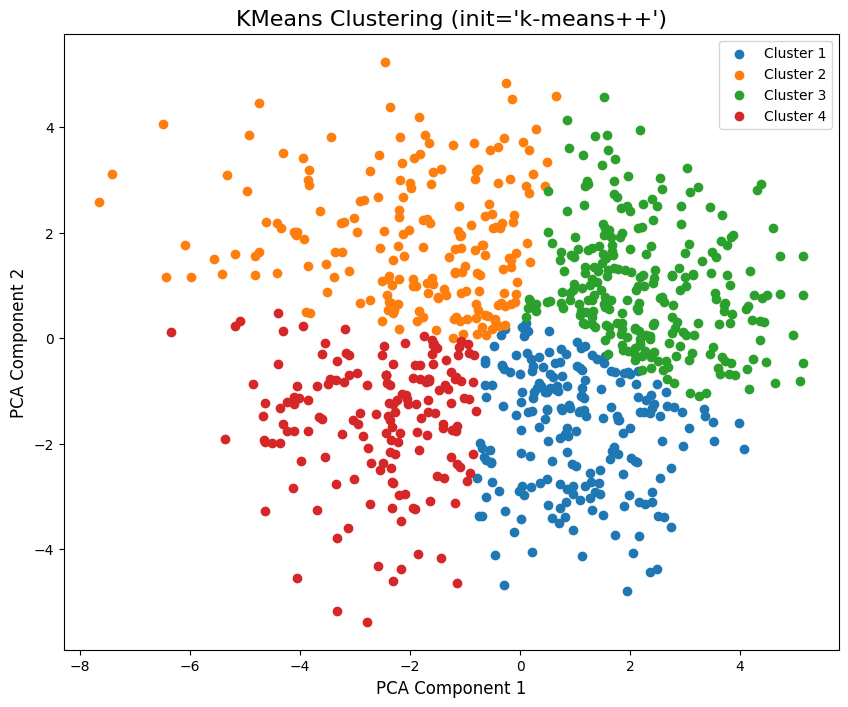

In [40]:
# Apply KMeans clustering with init='k-means++' for K=4
kmeans_kmeanspp = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_kmeanspp.fit(pca_result)

# Get the predicted cluster labels
labels_kmeanspp = kmeans_kmeanspp.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_kmeanspp == i, 0], pca_result[labels_kmeanspp == i, 1], label=f'Cluster {i+1}')

plt.title("KMeans Clustering (init='k-means++')", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()


###  (c) Bisecting K-means (sklearn.cluster.BisectingKMeans with init = ‘Random’) 

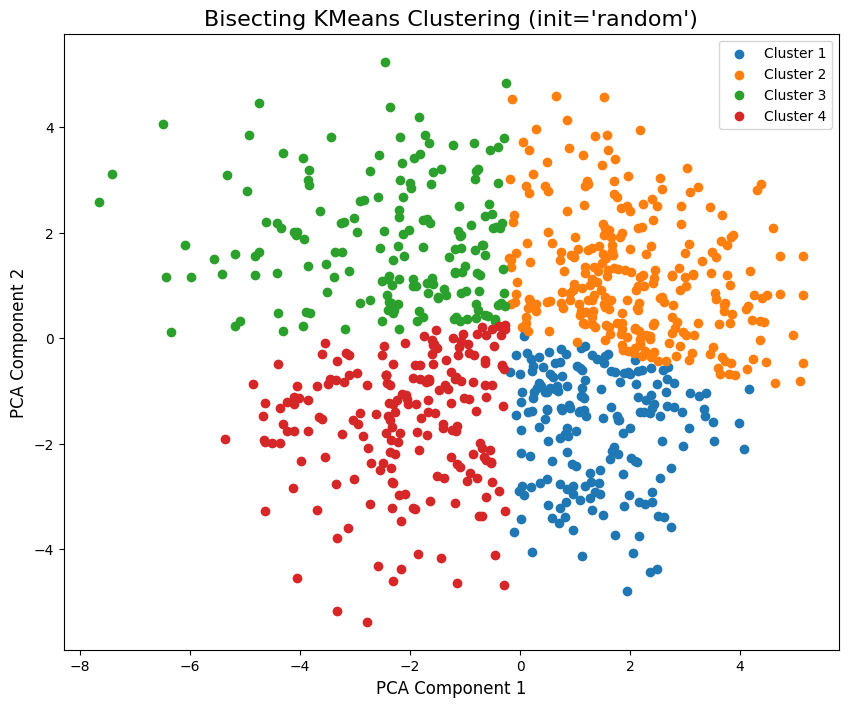

In [41]:
from sklearn.cluster import BisectingKMeans

# Apply Bisecting KMeans clustering with init='random' for K=4
bisecting_kmeans = BisectingKMeans(n_clusters=4, init='random', random_state=42)
bisecting_kmeans.fit(pca_result)

# Get the predicted cluster labels
labels_bisecting_kmeans = bisecting_kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_bisecting_kmeans == i, 0], pca_result[labels_bisecting_kmeans == i, 1], label=f'Cluster {i+1}')

plt.title("Bisecting KMeans Clustering (init='random')", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()


### (d) spectralclustering(sklearn.cluster.SpectralClusteringwithdefaultparameters)

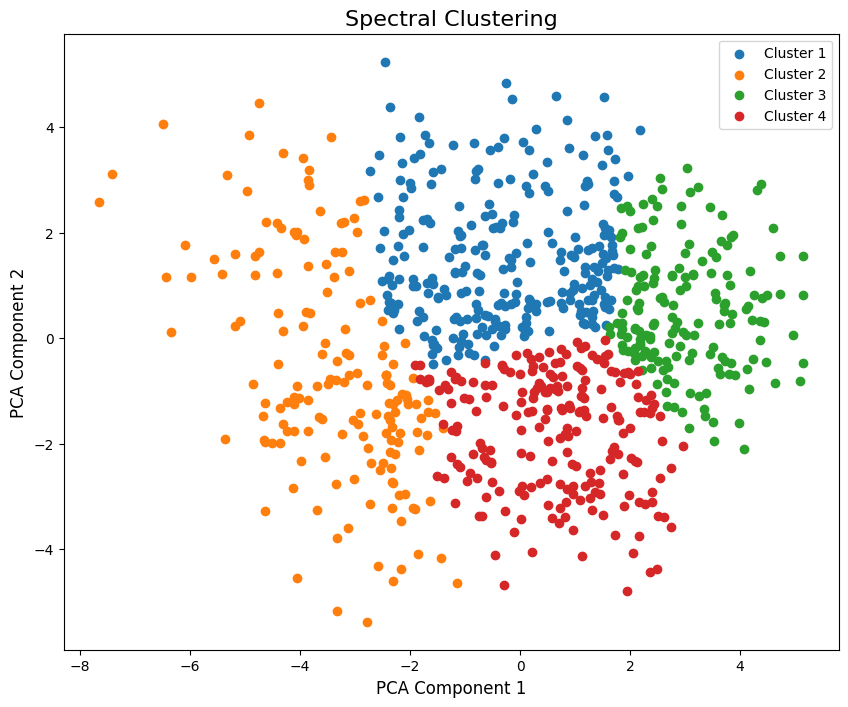

In [42]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering for K=4
spectral_clustering = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
labels_spectral = spectral_clustering.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_spectral == i, 0], pca_result[labels_spectral == i, 1], label=f'Cluster {i+1}')

plt.title("Spectral Clustering", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()


### DBSCAN(0.5 point)– What are the eps and min samples parameter values you used to get 4 clusters?

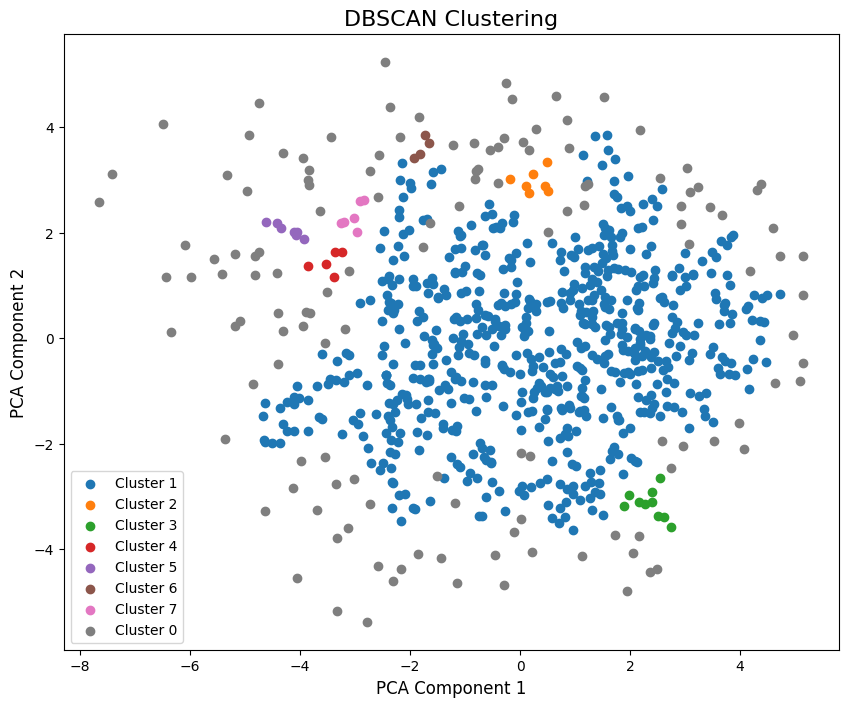

DBSCAN Parameters: eps = 0.4, min_samples = 5


In [43]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering with eps and min_samples for K=4 clusters
dbscan = DBSCAN(eps=0.4, min_samples=5)
labels_dbscan = dbscan.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in set(labels_dbscan):
    plt.scatter(pca_result[labels_dbscan == i, 0], pca_result[labels_dbscan == i, 1], label=f'Cluster {i+1}')

plt.title("DBSCAN Clustering", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()

# Printing the eps and min_samples parameters used
print(f"DBSCAN Parameters: eps = 0.4, min_samples = 5")


### Agglomerativeclustering

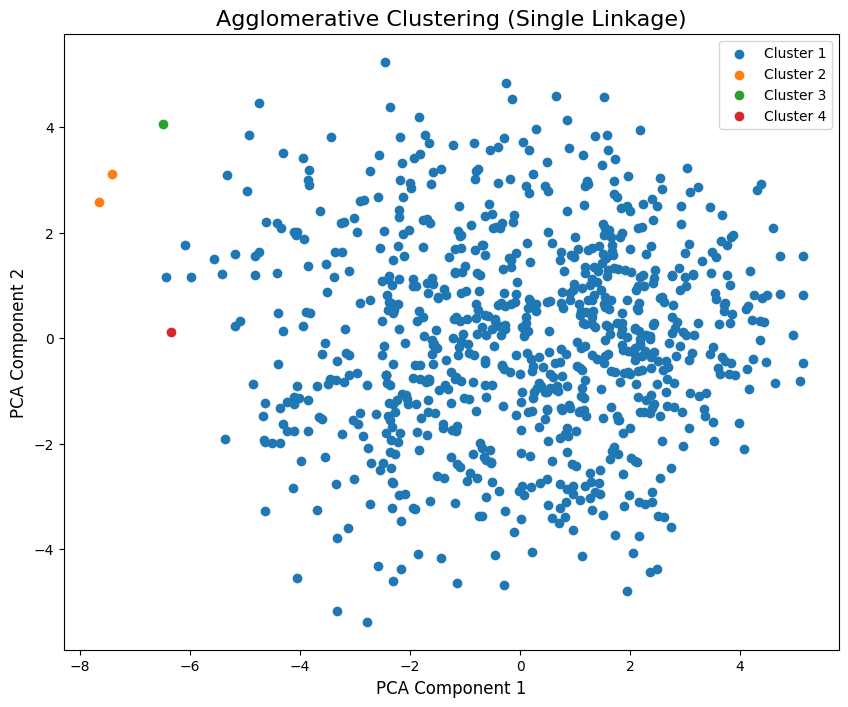

In [44]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering with 'single' linkage
agg_single = AgglomerativeClustering(n_clusters=4, linkage='single')
labels_single = agg_single.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_single == i, 0], pca_result[labels_single == i, 1], label=f'Cluster {i+1}')

plt.title("Agglomerative Clustering (Single Linkage)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()


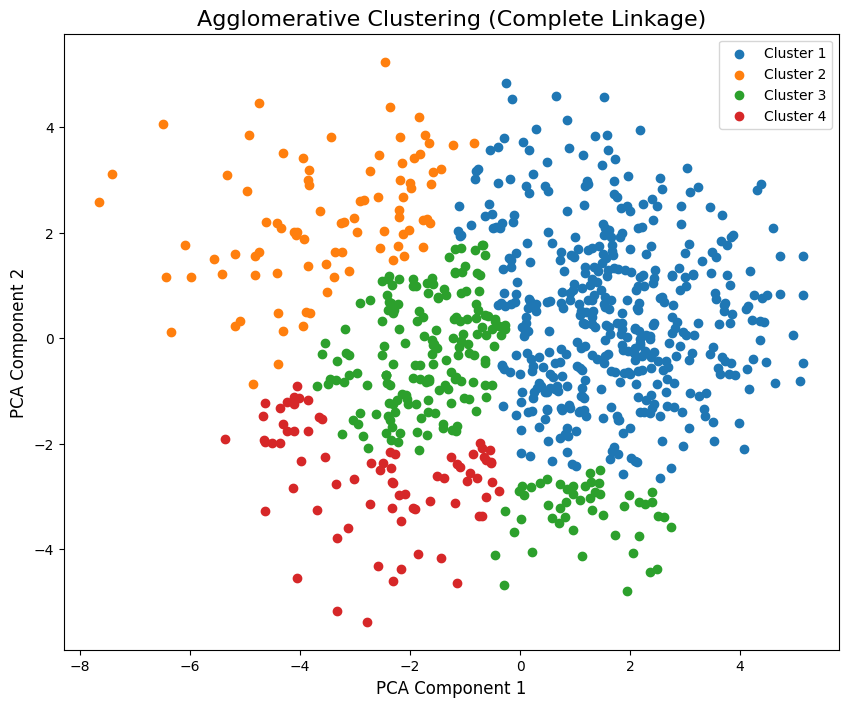

In [57]:
agg_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels_agg_complete = agg_single.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_single == i, 0], pca_result[labels_single == i, 1], label=f'Cluster {i+1}')

plt.title("Agglomerative Clustering (Complete Linkage)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()


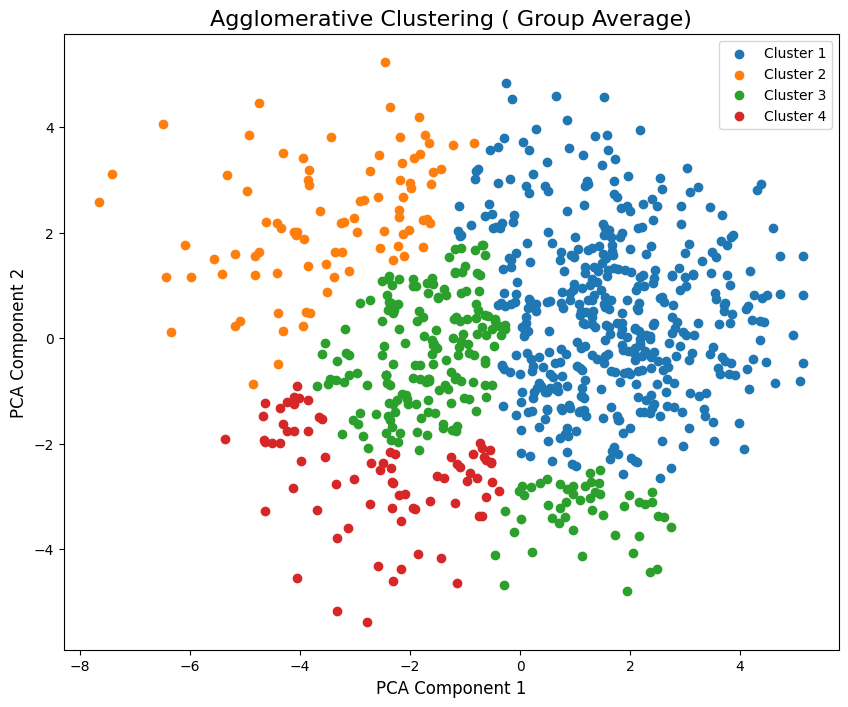

In [58]:
agg_average = AgglomerativeClustering(n_clusters=4, linkage='average')
labels_agg_average = agg_single.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_single == i, 0], pca_result[labels_single == i, 1], label=f'Cluster {i+1}')

plt.title("Agglomerative Clustering ( Group Average)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()

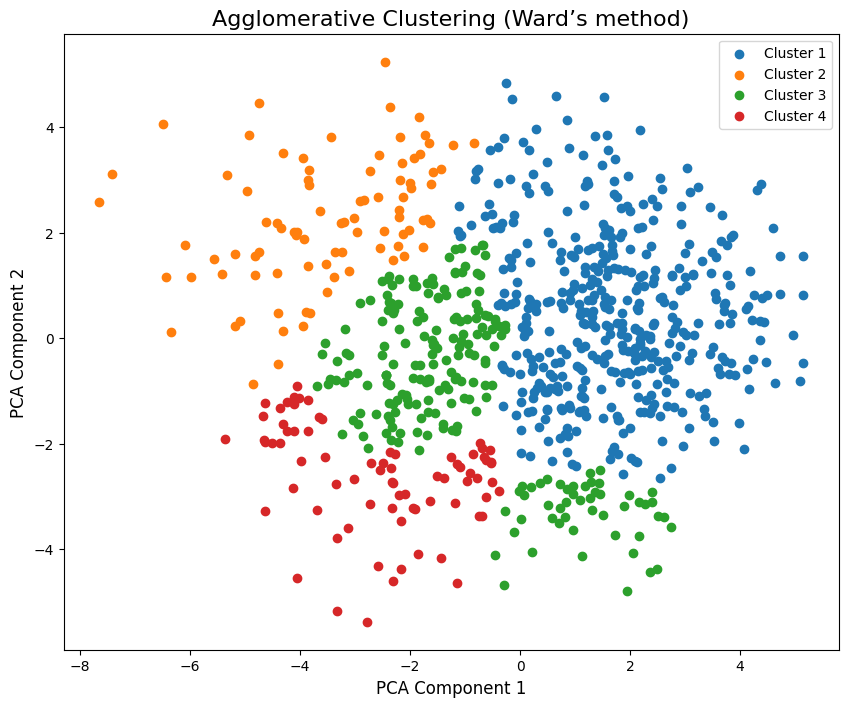

In [59]:

agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_agg_ward = agg_single.fit_predict(pca_result)

# Plot the clusters
plt.figure(figsize=(10, 8))
for i in range(4):
    plt.scatter(pca_result[labels_single == i, 0], pca_result[labels_single == i, 1], label=f'Cluster {i+1}')

plt.title("Agglomerative Clustering (Ward’s method)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend()
plt.show()

### 4. (Clustering Evaluations) For all the methods in Item 3:


###  (a) PerformclusteringperformanceevaluationusingFowlkes-Mallowsindex(sklearn.metrics.fowlkes_mallows_score). ComputetheFowlkes-Mallowsindexforeachmethodonthe2Ddataset. 

In [60]:
import os
import numpy as np

# Assuming the class_names list is defined
class_names = ['n02096177-cairn', 'n02096294-Australian_terrier', 'n02100735-English_setter', 'n02111500-Great_Pyrenees']

# Initialize an empty list for true labels
labels_true = []

# Loop through each class directory and assign labels based on the class
for class_index, class_name in enumerate(class_names):
    # Get the list of images for the current class
    class_path = os.path.join(dataset_path, class_name)  
    class_images = os.listdir(class_path)
    
    # Assign the current class label  to each image in that class
    labels_true.extend([class_index] * len(class_images))  
# Convert labels_true to a numpy array for compatibility with evaluation functions
labels_true = np.array(labels_true)


In [67]:
from sklearn.metrics import fowlkes_mallows_score

# Compute the Fowlkes-Mallows index for each clustering method
fowlkes_scores = {}

# For KMeans (Random init)
fowlkes_scores['KMeans (Random)'] = fowlkes_mallows_score(labels_true, labels_kmeans)

# For KMeans (k-means++ init)
fowlkes_scores['KMeans (k-means++)'] = fowlkes_mallows_score(labels_true, labels_kmeanspp)

# For Bisecting KMeans
fowlkes_scores['Bisecting KMeans'] = fowlkes_mallows_score(labels_true, labels_bisecting_kmeans)

# For Spectral Clustering
fowlkes_scores['Spectral Clustering'] = fowlkes_mallows_score(labels_true, labels_spectral)

# For DBSCAN
fowlkes_scores['DBSCAN'] = fowlkes_mallows_score(labels_true, labels_dbscan)

# For Agglomerative Clustering (Single Linkage)
fowlkes_scores['Agglomerative (Single Linkage)'] = fowlkes_mallows_score(labels_true, labels_single)

# Output Fowlkes-Mallows scores
for method, score in fowlkes_scores.items():
    print(f"{method}: Fowlkes-Mallows Index = {score:.4f}")


KMeans (Random): Fowlkes-Mallows Index = 0.2901
KMeans (k-means++): Fowlkes-Mallows Index = 0.2901
Bisecting KMeans: Fowlkes-Mallows Index = 0.2901
Spectral Clustering: Fowlkes-Mallows Index = 0.2836
DBSCAN: Fowlkes-Mallows Index = 0.4009
Agglomerative (Single Linkage): Fowlkes-Mallows Index = 0.3226


### (b) PerformclusteringperformanceevaluationusingSilhouetteCoefficient(sklearn.metrics.silhouette score).Compute the Silhouette Coefficient for each method. 

In [68]:
from sklearn.metrics import silhouette_score

# Compute the Silhouette Coefficient for each clustering method
silhouette_scores = {}

# For KMeans (Random init)
silhouette_scores['KMeans (Random)'] = silhouette_score(pca_result, labels_kmeans)

# For KMeans (k-means++ init)
silhouette_scores['KMeans (k-means++)'] = silhouette_score(pca_result, labels_kmeanspp)

# For Bisecting KMeans
silhouette_scores['Bisecting KMeans'] = silhouette_score(pca_result, labels_bisecting_kmeans)

# For Spectral Clustering
silhouette_scores['Spectral Clustering'] = silhouette_score(pca_result, labels_spectral)

# For DBSCAN
silhouette_scores['DBSCAN'] = silhouette_score(pca_result, labels_dbscan)

# For Agglomerative Clustering (Single Linkage)
silhouette_scores['Agglomerative (Single Linkage)'] = silhouette_score(pca_result, labels_single)

# Output Silhouette Coefficients
for method, score in silhouette_scores.items():
    print(f"{method}: Silhouette Coefficient = {score:.4f}")


KMeans (Random): Silhouette Coefficient = 0.3473
KMeans (k-means++): Silhouette Coefficient = 0.3473
Bisecting KMeans: Silhouette Coefficient = 0.3335
Spectral Clustering: Silhouette Coefficient = 0.3062
DBSCAN: Silhouette Coefficient = -0.2126
Agglomerative (Single Linkage): Silhouette Coefficient = 0.2659


### (c) Rankthemethodsfromthebesttothe worst for your dataset based on Fowlkes-Mallows index.

In [69]:
# Rank methods by Fowlkes-Mallows Index
ranked_fowlkes = sorted(fowlkes_scores.items(), key=lambda x: x[1], reverse=True)

print("\nRanking based on Fowlkes-Mallows Index:")
for rank, (method, score) in enumerate(ranked_fowlkes, start=1):
    print(f"{rank}. {method}: {score:.4f}")



Ranking based on Fowlkes-Mallows Index:
1. DBSCAN: 0.4009
2. Agglomerative (Single Linkage): 0.3226
3. KMeans (Random): 0.2901
4. KMeans (k-means++): 0.2901
5. Bisecting KMeans: 0.2901
6. Spectral Clustering: 0.2836


###  (d) Rank the methods from the best to the worst for your dataset based on Silhouette Coefficient.


In [70]:
# Rank methods by Silhouette Coefficient
ranked_silhouette = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

print("\nRanking based on Silhouette Coefficient:")
for rank, (method, score) in enumerate(ranked_silhouette, start=1):
    print(f"{rank}. {method}: {score:.4f}")



Ranking based on Silhouette Coefficient:
1. KMeans (Random): 0.3473
2. KMeans (k-means++): 0.3473
3. Bisecting KMeans: 0.3335
4. Spectral Clustering: 0.3062
5. Agglomerative (Single Linkage): 0.2659
6. DBSCAN: -0.2126
